# NCI WeatherBench-1a: Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

## Note: 
**Requires an 191GB ARE instance for the full dataset**

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
NOTEBOOK_DIR="/g/data/wb00/admin/testing/NCI_weatherbench/NCI_notebooks_v2/"
os.chdir(NOTEBOOK_DIR)
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
import logging 
import xarray as xr
from datetime import datetime
import dask
from dask.distributed import Client
import gc
from dask.diagnostics import ProgressBar
import IPython
from IPython.display import Javascript
from datetime import datetime


In [2]:
#client = Client(n_workers=12, threads_per_worker=1)  
client = Client(n_workers=18, threads_per_worker=1)  
client

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

<Client: 'tcp://127.0.0.1:35587' processes=18 threads=18, memory=95.00 GiB>

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data - '5.625'

First, we need to specify the directories and load the data.

In [5]:
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' # Location of WeatherBench dataset
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir" # Location to store baseline forecasts
print('DATADIR:', DATADIR)
print('PREDDIR:', PREDDIR)
! mkdir -p {PREDDIR} 

DATADIR: /g/data/wb00/NCI-Weatherbench/5.625deg
PREDDIR: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir


### Data directory structure

In [6]:
!ls '/g/data/wb00/NCI-Weatherbench/'

1.40625deg  2.8125deg  5.625deg  license.txt


In [7]:
!ls $DATADIR/

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants.nc		 temperature		       v_component_of_wind
geopotential		 toa_incident_solar_radiation  vorticity


In [8]:
xr.open_mfdataset(f'{DATADIR}/2m_temperature/*.nc', combine='by_coords', parallel=True)

<xarray.Dataset>
Dimensions:  (time: 561024, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 ... 2022-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [9]:
print( f'[{datetime.now().replace(microsecond=0)}]' )

#years = list(range(2012, 2022+1))
#z500_files = [ file for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*')   for year in years  ] 
#t850_files = [ file for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')    for year in years  ] 
#tp_files   = [ file for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*') for year in years  ]  
#t2m_files  = [ file for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*') for year in years  ]  
#years = list(range(2000, 2022+1))

year1 = 2000
year2 = 2022
years = list(range(year1, year2+1))
print (years)
z500_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*')  ] 
t850_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')    ] 
tp_files   = [ file for year in years for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*')   ]  
t2m_files  = [ file for year in years for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*')   ]  
#z500_files
#t850_files

[2024-03-07 10:46:11]
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [10]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Load the entire dataset for the relevant variables
#z500 = xr.open_mfdataset(get_files_list(f'{DATADIR}/geopotential/'), combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
#t850 = xr.open_mfdataset(get_files_list(f'{DATADIR}/temperature/'),  combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()  
z500 = xr.open_mfdataset(z500_files, combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(t850_files, combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()  

# convert to 6 hourly accumulation
#tp  = xr.open_mfdataset(get_files_list(f'{DATADIR}/total_precipitation/'), combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
#t2m = xr.open_mfdataset(get_files_list(f'{DATADIR}/2m_temperature/'),     combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load()  
tp  = xr.open_mfdataset(tp_files,  combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
t2m = xr.open_mfdataset(t2m_files, combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load()  
tp.name = 'tp'
data = xr.merge([z500, t850, tp, t2m]).compute()

[2024-03-07 10:47:59]
CPU times: user 8min 28s, sys: 29.2 s, total: 8min 57s
Wall time: 9min 57s


In [12]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Load the validation subset of the data: 2021 and 2022

v_year1 = 2021
v_year2 = 2022
#valid_years = list(range(2021, 2022+1))
valid_years = list(range(v_year1, v_year2+1))
print ('valid_years:', valid_years)
z500_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*') ] 
t850_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')  ] 
tp_valid_files   = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*') ] 
t2m_valid_files  = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*') ] 
#print (z500_valid_files)
#z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022')) #slice('2021', '2022'))
#t850_valid = load_test_data(f'{DATADIR}/temperature/',  't', slice('2021', '2022')) #slice('2021', '2022'))
#tp_valid = load_test_data(f'{DATADIR}/total_precipitation/', 'tp', slice('2021', '2022')).rolling(time=6).sum()
#z500_valid = load_test_data(z500_valid_files, 'z',  slice('2021', '2022')) #slice('2021', '2022'))
#t850_valid = load_test_data(t850_valid_files, 't',  slice('2021', '2022')) #slice('2021', '2022'))
#tp_valid   = load_test_data(tp_valid_files,   'tp', slice('2021', '2022')).rolling(time=6).sum()
#tp_valid.name = 'tp'
#t2m_valid = load_test_data(f'{DATADIR}/2m_temperature/', 't2m', slice('2021', '2022')) #slice('2021', '2022'))
#t2m_valid  = load_test_data(t2m_valid_files, 't2m', slice('2021', '2022')) #slice('2021', '2022'))

z500_valid = load_test_data(z500_valid_files, 'z',  slice(str(v_year1), str(v_year2) ))  
t850_valid = load_test_data(t850_valid_files, 't',  slice(str(v_year1), str(v_year2) ))  
tp_valid   = load_test_data(tp_valid_files,   'tp', slice(str(v_year1), str(v_year2) )).rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid  = load_test_data(t2m_valid_files, 't2m', slice(str(v_year1), str(v_year2) )) 
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid]).compute()

[2024-03-06 16:22:46]
valid_years: [2021, 2022]
load_test_data, var: z
load_test_data, var: t
load_test_data, var: tp
load_test_data, var: t2m
CPU times: user 31.4 s, sys: 2.96 s, total: 34.4 s
Wall time: 35.3 s


## Persistence forecast

Persistence simply means: Tomorrow's weather is today's weather.

In [13]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [14]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [17]:
%%time
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

CPU times: user 15.1 s, sys: 19.6 s, total: 34.8 s
Wall time: 23 s


In [18]:
persistence

<xarray.Dataset>
Dimensions:    (time: 17514, lat: 32, lon: 64, lead_time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 4.864e+04 4.864e+04 ... nan
    t          (lead_time, time, lat, lon) float32 254.0 254.0 253.9 ... nan nan
    tp         (lead_time, time, lat, lon) float32 nan nan nan ... nan nan nan
    t2m        (lead_time, time, lat, lon) float32 242.9 242.4 241.9 ... nan nan

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [20]:
%%time
# Save the predictions
#save_years='2000_2022'
save_years = f'{year1}_{year2}' 
print ('save_years:', save_years)
print ('Saving results:', f'{PREDDIR}/{save_years}_persistence_{res}.nc')
persistence.to_netcdf(    f'{PREDDIR}/{save_years}_persistence_{res}.nc')

save_years: 2000_2022
Saving results: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/2000_2022_persistence_5.625.nc
CPU times: user 5.36 s, sys: 11.3 s, total: 16.7 s
Wall time: 12 s


## Climatology forecast

First let's create a single climatology from the entire training dataset (meaning everything before 2021).

In [21]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [22]:
#train_data = data.sel(time=slice('1959', '2020'))
#train_data = data.sel(time=slice('2000', '2020'))
train_data = data.sel(time=slice( str(year1), '2020'))

In [23]:
climatology = create_climatology_forecast(train_data)

In [24]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (lat, lon) float32 4.889e+04 4.89e+04 ... 5.134e+04 5.134e+04
    t        (lat, lon) float32 241.8 242.0 242.0 241.8 ... 259.6 259.7 259.7
    tp       (lat, lon) float32 2.974e-05 2.882e-05 ... 0.0001745 0.0001792
    t2m      (lat, lon) float32 228.9 228.5 228.1 227.9 ... 259.8 260.0 260.1

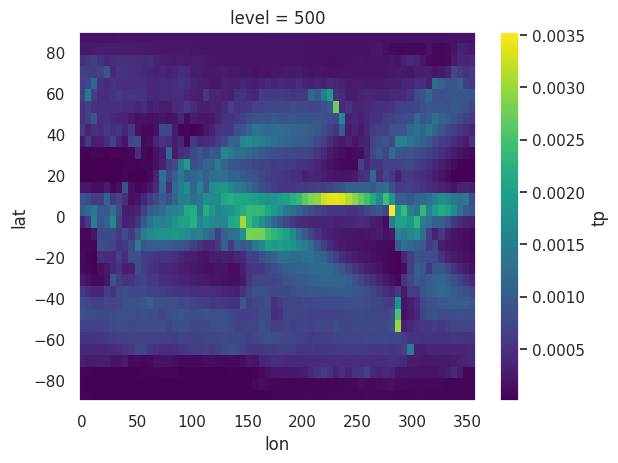

In [25]:
climatology.tp.plot();

In [26]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
print('Saving result:', f'{PREDDIR}/{save_years}_climatology_{res}.nc')
climatology.to_netcdf(  f'{PREDDIR}/{save_years}_climatology_{res}.nc')


[2024-03-06 16:30:55]
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/2000_2022_climatology_5.625.nc


## Climatology  forecast by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [27]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [28]:
%%time 
print( f'[{datetime.now().replace(microsecond=0)}]' )
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

[2024-03-06 16:31:18]
CPU times: user 45.2 s, sys: 2.21 s, total: 47.4 s
Wall time: 43.9 s


In [29]:
weekly_climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 53 53 53 53 53 53 53 53 53 ... 52 52 52 52 52 52 52 52
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 4.995e+04 4.997e+04 ... 4.996e+04
    t        (time, lat, lon) float32 255.1 255.2 255.2 ... 252.6 252.7 252.7
    tp       (time, lat, lon) float32 6.286e-06 7.235e-06 ... 0.0001715
    t2m      (time, lat, lon) float32 247.1 246.8 246.5 ... 250.4 250.7 250.9

In [30]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
print ('Saving result:',     f'{PREDDIR}/{save_years}_weekly_climatology_{res}.nc')
weekly_climatology.to_netcdf(f'{PREDDIR}/{save_years}_weekly_climatology_{res}.nc')

[2024-03-06 16:32:02]
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/2000_2022_weekly_climatology_5.625.nc


### Reset everything 

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)
IPython.Application.instance().kernel.do_shutdown(True)
client.shutdown()

### Note: 
Notebook 1b contains the same functions for higher resolution

# The End